In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### *Defining Useful Classes for Future Simulations*

In [204]:
class PoissonProcess:
    
    def __init__(self, lamb, duration, mu):
        """
        Args:
            lamb:                 Parameter lambda of the poisson distribution
            duration:             Duration of the poisson process (T)
            mu:                   Parameter mu of the exponentially distributed service times
            arrival_times:        Inter-arrival times of the customers
            service_times:        Service times of the customers
            number_of_customers:  Number of customers in the system
        """
        self.lamb = lamb
        self.duration = duration
        self.mu = mu
        self.arrivals_services()

    def arrivals_services(self):
        random_number = int(np.random.poisson(self.lamb * self.duration * 1.3))
        inter_arrivals = np.random.exponential(1 / self.lamb, size=random_number)
        arrival_times = np.cumsum(inter_arrivals)
        self.arrival_times = list(arrival_times[arrival_times <= self.duration])
        self.number_of_customers = len(self.arrival_times)
        self.service_times = list(np.random.exponential(self.mu, size=self.number_of_customers))

    def simulate_mmk(self, k: int) -> list:
        """
        Calculates the waiting time for M/M/k Queue
        Args:
            k: the number of servers available
        
        Returns: The waiting times of the customers in the system
        """
        assert len(self.arrival_times) == len(self.service_times)  # Just to make sure

        waiting_times = []
        next_idle_times = np.zeros(k)
        for i in range(self.number_of_customers):
            earliest_finish_time = min(next_idle_times)
            index_server = np.argmin(next_idle_times)
            new_start_time = max(earliest_finish_time, self.arrival_times[i])
            new_wait_time = max(0, new_start_time - self.arrival_times[i])
            new_finish_time = new_start_time + self.service_times[i]
            next_idle_times[index_server] = new_finish_time
            waiting_times.append(new_wait_time)
        return waiting_times

    def get_waiting_times(self, waiting: list, limit=None):
        """
        Args:
            waiting: waiting times of the customers
            limit: 2 element list. First element is the start and second element is the end of the interval

        Returns: The waiting times for the given limit.
                    If limit=None, Then all waiting times are returned for the duration T
        """
        if limit is None:
            lower_bound = 0
            upper_bound = self.duration
        else:
            lower_bound = limit[0]
            upper_bound = limit[1]
        interval = [num for num in self.arrival_times if lower_bound <= num <= upper_bound]
        lower_index = self.arrival_times.index(interval[0])
        upper_index = self.arrival_times.index(interval[len(interval) - 1])
        desired_waiting_times = waiting[lower_index:upper_index + 1]
        return desired_waiting_times

    def get_arrival_times(self, limit=None):
        """
        Args:
            limit: 2 element list. First element is the start and second element is the end of the interval

        Returns: Arrival times for customers in the given interval
        """
        if limit is None:
            lower_bound = 0
            upper_bound = self.duration
        else:
            lower_bound = limit[0]
            upper_bound = limit[1]
        interval = [num for num in self.arrival_times if lower_bound <= num <= upper_bound]
        return interval


class InhomogeneousPoisson(PoissonProcess):

    def __init__(self, lambda_function, duration, mu):
        """
        Args:
            lambda_function: equation of the time_varying lambda function
            duration: Duration of the process
        """
        self.lambda_function = lambda_function
        self.duration = duration
        self.upper_bound = self.find_upper_bound()
        super().__init__(self.upper_bound, self.duration, mu)
        self.inhomogeneous_arrivals = self.generate()
        self.arrival_times = self.inhomogeneous_arrivals

    def find_upper_bound(self):
        """Returns: Upper bound of the lambda function"""
        x_values = np.linspace(0, self.duration, 1000000)
        y_values = self.lambda_function(x_values)
        upper_bound = max(y_values) * 1.1
        return upper_bound

    def generate(self):
        """
        Utilizes the thinning method to simulate time varying poisson process
        Returns: The inhomogeneous inter-arrival times"""
        inhomogeneous = []
        for arrival in self.arrival_times:
            u = np.random.uniform(0, 1, size=1)
            if u <= self.lambda_function(arrival) / self.upper_bound:
                inhomogeneous.append(arrival)
        return inhomogeneous

class Queue:

    def __init__(self, customers: list, mu):
        self.normal_customers: PoissonProcess = customers[0]
        self.normal_service_times = list(
            np.random.exponential(mu,
                                  size=len(self.normal_customers.arrival_times)))
        if len(customers) > 1:
            self.special_customers: InhomogeneousPoisson = customers[1]
            self.special_service_times = list(
                np.random.exponential(mu,
                                      size=len(self.special_customers.inhomogeneous_arrivals)))
    
    @staticmethod
    def serve(server, arrivals: list, services: list, waiting_times: list):
        """
        Calculates the waiting time for the giving type of customer. Removes the customer's arrival and
        service times from the list. Also, calculates the server finish time.
        Args:
            server: Server finish time for either normal or special server
            arrivals: Arrival times of the customers
            services: Service times of the customers
            waiting_times: Waiting times of the customers

        Returns: server finish time, customer arrival times, customer service times, waiting times
        """
        start_time = max(server, arrivals[0])
        wait_time = max(0, start_time - arrivals[0])
        finish_time = start_time + services[0]
        server = finish_time
        waiting_times.append(wait_time)
        arrivals = arrivals[1:]
        services = services[1:]
        return server, arrivals, services, waiting_times

    def server_simulation(self):
        """Algorithm to simulate waiting times for both special and normal customers"""
        special_customer_length = len(self.special_customers.inhomogeneous_arrivals)  # number of special customers
        normal_customer_length = len(self.normal_customers.arrival_times)  # number of normal customers
        normal_arrivals = self.normal_customers.arrival_times  # arrival times of the normal customers
        special_arrivals = self.special_customers.inhomogeneous_arrivals  # arrival times of the special customers
        normal_services = self.normal_service_times  # service times required for the normal customers
        special_services = self.special_service_times  # service times required for the special customers
        
        # making sure that number of arrivals equal to the number of available service times
        assert len(normal_arrivals) == len(normal_services) 
        assert len(special_arrivals) == len(special_services)

        normal_server = 0   # earliest finish time for the normal server
        special_server = 0  # earliest finish time for the special server
        special_waiting_times = []  # waiting times for the special customers
        normal_waiting_times = []  # waiting times for the normal customers

        # run until getting all of the waiting times
        while len(special_waiting_times) != special_customer_length \
                and len(normal_waiting_times) != normal_customer_length: 
            
            # if there are no more arrivals, stop the algorithm
            if len(normal_arrivals) == 0 and len(special_arrivals) == 0:
                break
            
            # if there are only special customers left, second server serves to the special customers
            elif len(normal_arrivals) == 0:
                special_server, special_arrivals, special_services, special_waiting_times = self.serve(
                    special_server, special_arrivals, special_services, special_waiting_times)
            
            # if there only normal customers left, decide which server are going to serve them
            elif len(special_arrivals) == 0:
                
                # if normal server finishes earlier or at the same time as special server,
                # normal server serves to the next normal customer
                if normal_server <= special_server:
                    normal_server, normal_arrivals, normal_services, normal_waiting_times = self.serve(
                        normal_server, normal_arrivals, normal_services, normal_waiting_times)
                    
                # if special server finishes earlier than the normal server, special server
                # serves to the next normal customer
                else:
                    special_server, normal_arrivals, normal_services, normal_waiting_times = self.serve(
                        special_server, normal_arrivals, normal_services, normal_waiting_times)

            # If there are still both type of customers
            else:   
                # if the first normal customer arrives before the first special customer
                if normal_arrivals[0] < special_arrivals[0]:

                    # if normal server finishes earlier or at the same time as the special server,
                    # normal server serves to the next normal customer
                    if normal_server <= special_server:
                        normal_server, normal_arrivals, normal_services, normal_waiting_times = self.serve(
                            normal_server, normal_arrivals, normal_services, normal_waiting_times)
                        
                    # if special server finishes earlier than the first special customer arrival time,
                    # special server will serve to the first normal customer
                    elif special_server < special_arrivals[0]:
                        special_server, normal_arrivals, normal_services, normal_waiting_times = self.serve(
                            special_server, normal_arrivals, normal_services, normal_waiting_times)
                    
                    # if special server finishes later than the first special customer arrival time,
                    # special server will serve to the first special customer
                    else:
                        special_server, special_arrivals, special_services, special_waiting_times = self.serve(
                            special_server, special_arrivals, special_services, special_waiting_times)
                
                # if the first special customer arrives before or at the same time as the first normal customer,
                # special server will serve to the first special customer
                else:
                    special_server, special_arrivals, special_services, special_waiting_times = self.serve(
                        special_server, special_arrivals, special_services, special_waiting_times)

        return normal_waiting_times, special_waiting_times
    
    

### *Setting up the time-varying lambda function*

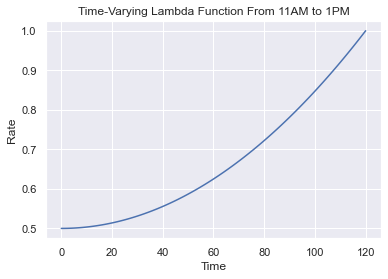

In [205]:
a = 1 / (2 * (120**2))
c = 1/2
lambda_func = lambda x: a*(x**2) + c # y = a(x-h)**2 + k where (h,k) is the vertex == (0,0.5)
values = np.arange(0,121, 1)
lst = lambda_func(values)
min_val = min(lst)
plt.plot(values,lst)
plt.title('Time-Varying Lambda Function From 11AM to 1PM')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.show()

### *Creating two types of customers: Normal and VIP*
For the sake of getting intuitive results, I have created below a visualization to check the number of arrivals for normal and VIP customers.

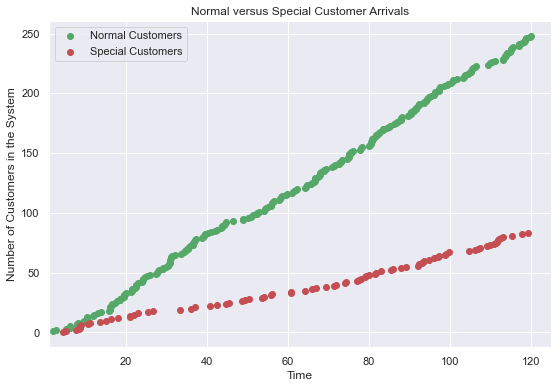

In [206]:
normal_customers = PoissonProcess(lamb=2, duration=120, mu=7/12)
vip_customers = InhomogeneousPoisson(lambda_function=lambda_func, duration=120, mu=7/12)

plt.figure(figsize=[9,6])
length = len(normal_customers.arrival_times)
plt.scatter(normal_customers.arrival_times, np.arange(length), c='g', label='Normal Customers')
length = len(vip_customers.inhomogeneous_arrivals)
plt.scatter(vip_customers.inhomogeneous_arrivals, np.arange(length), c='r', label='Special Customers')
plt.legend()
plt.xlim(1,125)
plt.title('Normal versus Special Customer Arrivals')
plt.ylabel('Number of Customers in the System')
plt.xlabel('Time')
plt.show()

### *Part i)*

In [213]:
waiting_means = []
for i in range(50):
    normal_customers = PoissonProcess(lamb=2, duration=120, mu=7/12)
    vip_customers = InhomogeneousPoisson(lambda_function=lambda_func, duration=120, mu=7/12)
    all_customers = [normal_customers, vip_customers]
    queue_simulation = Queue(customers=all_customers, mu=7/12)
    normal, special = queue_simulation.server_simulation()
    waiting_times = vip_customers.get_waiting_times(special, limit=[105,120])
    if waiting_times:
        waiting_means.append(np.mean(waiting_times))
expected_val = np.mean(waiting_means)
print('Out of 50 independent day simulations, expectation of the averaged waiting time')
print('for the second stream (VIP Customers) who arrive at food truck between 12:45 PM to 1:00 PM')
print('is {}'.format(expected_val))


Out of 50 independent day simulations, expectation of the averaged waiting time
for the second stream (VIP Customers) who arrive at food truck between 12:45 PM to 1:00 PM
is 1.092016156814008


### *Part ii)*

In [214]:
waiting_means = []
for i in range(50):
    normal_customers = PoissonProcess(lamb=2, duration=120, mu=7/12)
    vip_customers = InhomogeneousPoisson(lambda_function=lambda_func, duration=120, mu=7/12)
    all_customers = [normal_customers, vip_customers]
    queue_simulation = Queue(customers=all_customers, mu=7/12)
    normal, special = queue_simulation.server_simulation()
    waiting_times = normal_customers.get_waiting_times(normal, limit=[105,120])
    if waiting_times:
        waiting_means.append(np.mean(waiting_times))
expected_val = np.mean(waiting_means)
print('Out of 50 independent day simulations, expectation of the averaged waiting time')
print('for the second stream (VIP Customers) who arrive at food truck between 12:45 PM to 1:00 PM')
print('is {}'.format(expected_val))

Out of 50 independent day simulations, expectation of the averaged waiting time
for the second stream (VIP Customers) who arrive at food truck between 12:45 PM to 1:00 PM
is 1.6020471113807273


Compare to the answer we got in Deliverable 2 part b.) ii.), the expected waiting time in this situation is lower because of the fact that now there exists another server. Even though this additional server prioritizes the special customers, it serves to normal customer in the absence of special customers. Therefore, it decreases the accumulation of normal customers in queue; and, hence, decreases the expected waiting time for normal customers during the given interval.  